# iPrint Recommendation System
This notebook implements a recommendation system using:
- **ALS (Alternating Least Squares) for Collaborative Filtering**
- **Content-Based Filtering using TF-IDF**
- **Flask API for Deployment**

In [161]:
!pip install implicit
import pathlib
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from implicit.als import AlternatingLeastSquares # This line should work after installing the package
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [162]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/News Recommended/data")
print(data_dir_train)

if data_dir_train.exists():
    print("The directory exists.")
else:
    print("The directory does not exist.")

# Check if the file exists before attempting to read it
import os
file_path = os.path.join(data_dir_train, "consumer_transanctions.csv") # Construct the full file path

if os.path.exists(file_path):
    # Explicitly specify the data type for column 4 (index 4) as string
    consumer_transactions = pd.read_csv(file_path, dtype={'column_name': str}, low_memory=False)
    # Replace 'column_name' with the actual name of the column
    # print(consumer_transactions)

    platform_content = pd.read_csv(os.path.join(data_dir_train, "platform_content.csv"), low_memory=False) # Similar fix for platform_content
    # Replace 'column_name' with the actual name of the column
    # print(platform_content)
else:
    print(f"File not found at: {file_path}")

/content/drive/My Drive/Colab Notebooks/Upgrad Assignment/News Recommended/data
The directory exists.


Reading Data sent

In [164]:
consumer_transactions.head()


,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN


In [165]:
platform_content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


## Data Preprocessing

# Filtering only English articles

In [166]:
platform_content = platform_content[platform_content['language'] == 'en']

# Creating a rating system based on interaction type
interaction_weights = {
    'content_followed': 5,
    'content_commented_on': 4,
    'content_saved': 3,
    'content_liked': 2,
    'content_watched': 1
}
consumer_transactions['ratings'] = consumer_transactions['interaction_type'].map(interaction_weights)


In [167]:
consumer_transactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,ratings
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,5
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,1


# Merge datasets to create consumer interactions dataset

In [168]:
print("Unique item_id in consumer_transactions:", consumer_transactions['item_id'].nunique())
print("Unique item_id in platform_content:", platform_content['item_id'].nunique())

# Find the common item_ids
common_items = set(consumer_transactions['item_id']).intersection(set(platform_content['item_id']))
print("Number of common item_id:", len(common_items))


Unique item_id in consumer_transactions: 2987
Unique item_id in platform_content: 2218
Number of common item_id: 2154


In [169]:
consumer_interactions = consumer_transactions.merge(platform_content[['item_id', 'title', 'text_description', 'language']], on='item_id', how='inner')

# Now, filter only English articles
# consumer_interactions = consumer_interactions[consumer_interactions['language'] == 'English']

In [170]:
consumer_interactions.head()

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,ratings,title,text_description,language
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...,en
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1,Top 10 Intranet Trends of 2016,"Summary: Hero images, carousels, fat footers, ...",en
2,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,1,How This Googler Redesigned The Workweek,Jake Knapp has always been concerned about the...,en
3,1465415066,content_watched,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1,Chrome DevTools - Console API Reference,The DevTools docs have moved! Read the latest ...,en
4,1465413771,content_watched,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN,1,"Google, Amazon and the upcoming battle over AI...",The stage is set for the coming battle between...,en


# Exploratory Data Analysis

In [171]:
print("Dataset Overview:")
print(consumer_transactions.info())
print(platform_content.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
 8   ratings               72312 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 5.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2264 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       2264 non-null   int64 
 1   interaction_

# Distribution of interaction types

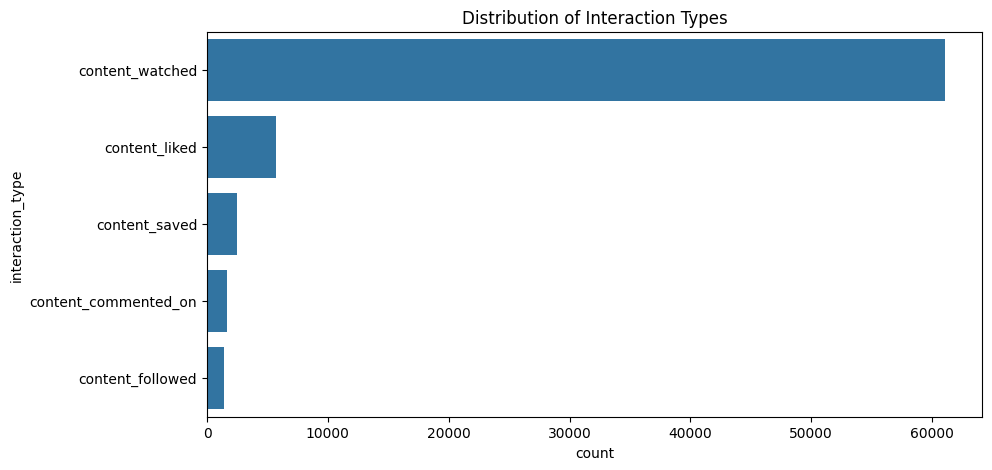

In [172]:
plt.figure(figsize=(10,5))
sns.countplot(y=consumer_transactions['interaction_type'], order=consumer_transactions['interaction_type'].value_counts().index)
plt.title("Distribution of Interaction Types")
plt.show()

# Most common consumer locations

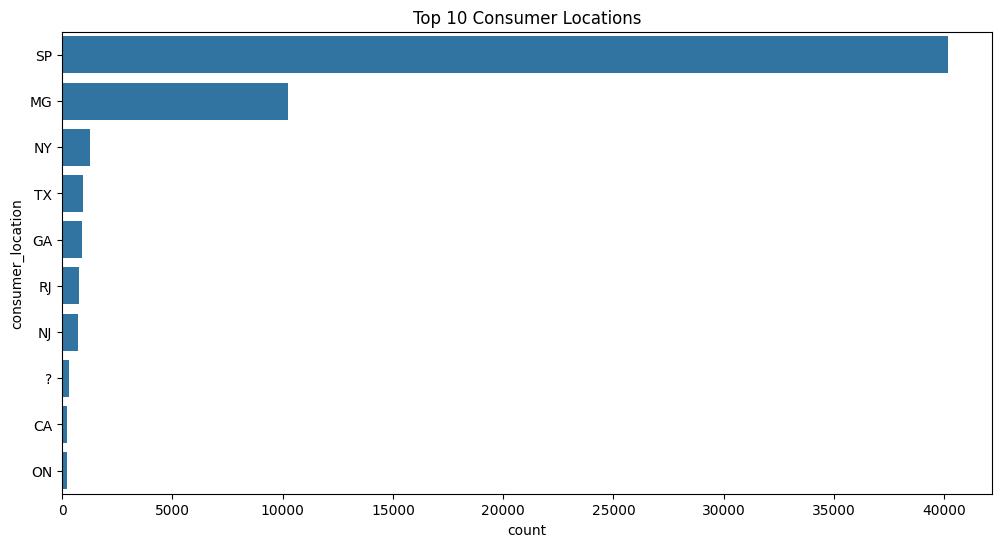

In [173]:
plt.figure(figsize=(12,6))
sns.countplot(y=consumer_transactions['consumer_location'], order=consumer_transactions['consumer_location'].value_counts().index[:10])
plt.title("Top 10 Consumer Locations")
plt.show()

# Most common producer locations

In [174]:
platform_content.head()


,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


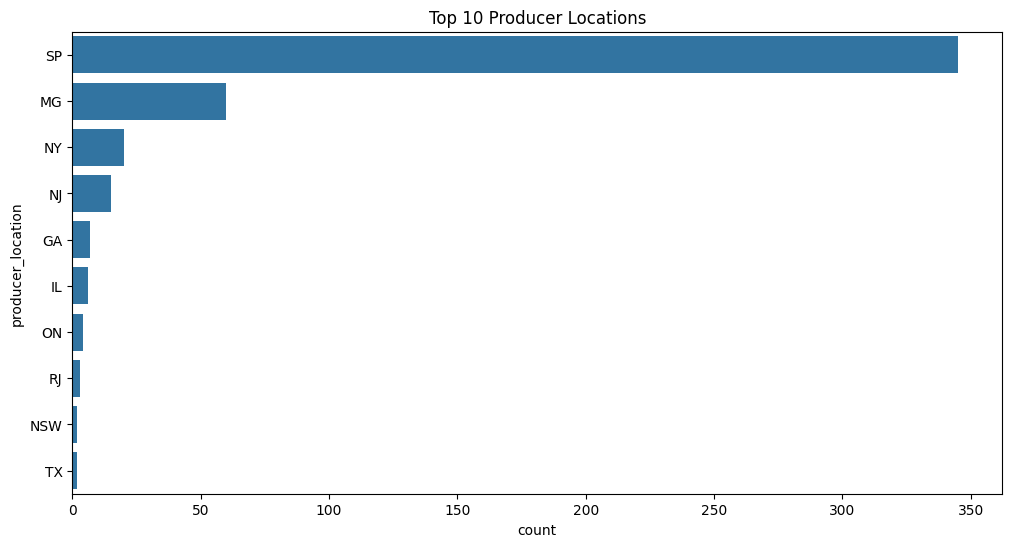

In [175]:
plt.figure(figsize=(12,6))
sns.countplot(y=platform_content['producer_location'], order=platform_content['producer_location'].value_counts().index[:10])
plt.title("Top 10 Producer Locations")
plt.show()

# Most common languages

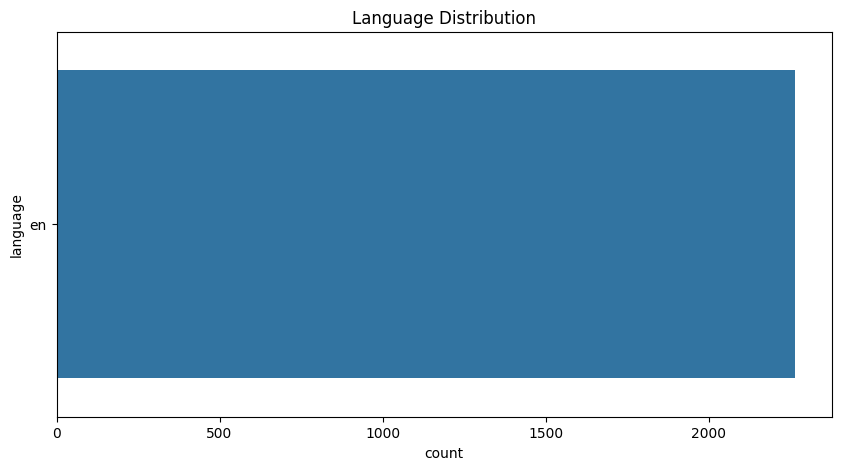

In [176]:
plt.figure(figsize=(10,5))
sns.countplot(y=platform_content['language'], order=platform_content['language'].value_counts().index)
plt.title("Language Distribution")
plt.show()

# Most popular articles by interaction count

In [177]:
popular_articles = consumer_transactions['item_id'].value_counts().head(10).index
popular_titles = platform_content[platform_content['item_id'].isin(popular_articles)][['item_id', 'title']]
print("Top 10 Most Popular Articles:")
print(popular_titles)

Top 10 Most Popular Articles:
                  item_id                                              title
1317  8657408509986329668               Pull request first - Practical Blend
1902 -8208801367848627943  Ray Kurzweil: The world isn't getting worse - ...
1942  2581138407738454418       10 Modern Software Over-Engineering Mistakes
3096 -4029704725707465084  Former Google career coach shares a visual tri...


# User-based Collaborative Filtering

In [178]:
def user_based_recommendations(user_id, num_recommendations=10):
    user_item_matrix = consumer_interactions.pivot_table(index='consumer_id', columns='item_id', values='ratings', fill_value=0)
    user_sim_matrix = cosine_similarity(user_item_matrix)
    user_sim_df = pd.DataFrame(user_sim_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

    similar_users = user_sim_df[user_id].sort_values(ascending=False)[1:num_recommendations+1].index
    recommended_items = consumer_interactions[consumer_interactions['consumer_id'].isin(similar_users)][['item_id', 'title']].drop_duplicates()

    return recommended_items.head(num_recommendations)

#Create User-Item Matrix

In [179]:
user_item_matrix = consumer_interactions.pivot_table(index='consumer_id', columns='item_id', values='ratings', fill_value=0)
print("User-Item Matrix Shape:", user_item_matrix.shape)
print(user_item_matrix.head())

User-Item Matrix Shape: (1644, 2154)
item_id               -9192549002213406534  -9190737901804729417  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9189659052158407108  -9171475473795142532  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id  

Find the user-similarity matrix based on a similarity measure.

In [180]:
from sklearn.metrics.pairwise import cosine_similarity

user_sim_matrix = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_sim_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

print("User Similarity Matrix Shape:", user_sim_df.shape)
print(user_sim_df.head())


User Similarity Matrix Shape: (1644, 1644)
consumer_id           -9223121837663643404  -9212075797126931087  \
consumer_id                                                        
-9223121837663643404              1.000000               0.00000   
-9212075797126931087              0.000000               1.00000   
-9207251133131336884              0.000000               0.29277   
-9199575329909162940              0.124274               0.00000   
-9196668942822132778              0.000000               0.00000   

consumer_id           -9207251133131336884  -9199575329909162940  \
consumer_id                                                        
-9223121837663643404               0.00000              0.124274   
-9212075797126931087               0.29277              0.000000   
-9207251133131336884               1.00000              0.000000   
-9199575329909162940               0.00000              1.000000   
-9196668942822132778               0.00000              0.000000   

con

Generate Predicted Ratings for All User-Item Pairs

In [181]:
predicted_ratings = np.dot(user_sim_matrix, user_item_matrix)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

print("Predicted Ratings Shape:", predicted_ratings_df.shape)
print(predicted_ratings_df.head())


Predicted Ratings Shape: (1644, 2154)
item_id               -9192549002213406534  -9190737901804729417  \
consumer_id                                                        
-9223121837663643404              2.587792              0.218945   
-9212075797126931087              0.802197              0.000000   
-9207251133131336884              1.527976              0.197965   
-9199575329909162940              0.317383              0.182321   
-9196668942822132778              0.667030              0.000000   

item_id               -9189659052158407108  -9171475473795142532  \
consumer_id                                                        
-9223121837663643404              1.490429              0.326803   
-9212075797126931087              0.774367              0.000000   
-9207251133131336884              0.958230              0.148995   
-9199575329909162940              0.307252              0.077322   
-9196668942822132778              0.292964              0.000000   

item_id 

Get Recommendations for a User

In [182]:
user_id = -9223121837663643404
recommendations = user_based_recommendations(user_id, num_recommendations=10)
print(recommendations)

                  item_id                                              title
1862  7229629480273331039  An independent organization just ranked Google...
2074  -240359174314633445  Comparing React.js to Vue.js for dynamic tabul...
2236  2072448887839540892  Welcome to GoogleBank, Facebook Bank, Amazon B...
2240  7516228655554309785        A digital crack in banking's business model
2249 -6484638837208285334  5 awesome Google Keep features you aren't usin...
2625  4369833742675497700   Transforming life insurance with design thinking
3732  4814419120794996930  Netflix says Geography, Age, and Gender are "G...
3733  -450825503558460924  Tetra Pak Cheese and Powder Systems acquires L...
4447  5270696484536580646               8 Insanely Simple Productivity Hacks
5145   764116021156146784  If you think women in tech is just a pipeline ...


# Item-based Collaborative Filtering

In [183]:
def item_based_recommendations(item_id, num_recommendations=10):
    item_user_matrix = consumer_interactions.pivot_table(index='item_id', columns='consumer_id', values='ratings', fill_value=0)
    item_sim_matrix = cosine_similarity(item_user_matrix)
    item_sim_df = pd.DataFrame(item_sim_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)

    similar_items = item_sim_df[item_id].sort_values(ascending=False)[1:num_recommendations+1].index
    recommended_items = consumer_interactions[consumer_interactions['item_id'].isin(similar_items)][['item_id', 'title']].drop_duplicates()

    return recommended_items.head(num_recommendations)

#Find the item-similarity matrix based on a similarity measure.

In [184]:
item_user_matrix = consumer_interactions.pivot_table(index='item_id', columns='consumer_id', values='ratings', fill_value=0)
item_sim_matrix = cosine_similarity(item_user_matrix)

item_sim_df = pd.DataFrame(item_sim_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)

print("Item Similarity Matrix Shape:", item_sim_df.shape)
print(item_sim_df.head())


Item Similarity Matrix Shape: (2154, 2154)
item_id               -9192549002213406534  -9190737901804729417  \
item_id                                                            
-9192549002213406534              1.000000                   0.0   
-9190737901804729417              0.000000                   1.0   
-9189659052158407108              0.098583                   0.0   
-9171475473795142532              0.118958                   0.0   
-9166778629773133902              0.206041                   0.0   

item_id               -9189659052158407108  -9171475473795142532  \
item_id                                                            
-9192549002213406534              0.098583              0.118958   
-9190737901804729417              0.000000              0.000000   
-9189659052158407108              1.000000              0.000000   
-9171475473795142532              0.000000              1.000000   
-9166778629773133902              0.089712              0.000000   

ite

#Generate the Top 10 Similar and Relevant Items

In [185]:
item_id = -9189659052158407108
similar_items = item_sim_df[item_id].sort_values(ascending=False)[1:11].index

recommended_items = consumer_interactions[consumer_interactions['item_id'].isin(similar_items)][['item_id', 'title']].drop_duplicates()
print("Top 10 Similar Items:")
print(recommended_items)

Top 10 Similar Items:
                   item_id                                              title
23879 -3700095596785790870   How to Design a Walkthrough That Users Will Read
25680  4695698299220703541           Android - The dark side of Jack and Jill
27753 -1634742667970363668  Google Cloud Platform's preemptible VMs are no...
27900  6317717254029043123  Apple makes it easier to for developers to upl...
29010  5217724704513784613  You SHOULD Learn Vanilla JavaScript Before JS ...
34282 -7448252416950961815  Apple Unveils iPhone 7 Alongside 7 Plus With D...
35066  4577451034168098359                                               Cubr
36532  2628816849077589497  Today in Apple history: Steve Jobs passes away...
42772 -4608017393995766765  Graphene and Silly Putty Creates a Super-Sensi...
43288 -7534240757267992657                Building on Slack Saved Our Startup


#Calling the Item-Based Recommendation Function

In [186]:
item_id = -3700095596785790870
recommendations = item_based_recommendations(item_id, num_recommendations=10)
print(recommendations)

                   item_id                                              title
325     511891900317865118  Why porting an iOS design to Android will not ...
365   -1590585250246572231  Why and How to Avoid Hamburger Menus - Louie A...
1095   5979676385148714519  Here's what Viv looks like, the next generatio...
1648   6045455576279706291  Google isn't abandoning Hangouts for its new c...
2529   4153717385931831462  Twitter killed Magic Recs, the only useful bot...
2789  -2516726696296387544  When will AI and NLP actually turn Siri into y...
2830  -7891960098457323262  Dag Kittlaus, co-founder of Siri, will give th...
7121   2285392309373358857  How Apple Keyboards Lost a Logo and Windows PC...
17080  8413971365124666862  Building Chatbots with Node.js - Online Traini...
26307 -1111518890369033396         The Business Case for Progressive Web Apps


# Content-based Filtering using TF-IDF

In [187]:
def content_based_recommendations(user_id, num_recommendations=10):
    tfidf = TfidfVectorizer(stop_words='english') # Changed 'en' to 'english'
    tfidf_matrix = tfidf.fit_transform(platform_content['text_description'].fillna(""))
    cosine_sim = cosine_similarity(tfidf_matrix)

    user_articles = consumer_interactions[consumer_interactions['consumer_id'] == user_id]['item_id'].tolist()
    similar_scores = cosine_sim[user_articles].mean(axis=0)
    similar_indices = similar_scores.argsort()[::-1][:num_recommendations]

    recommended_items = platform_content.iloc[similar_indices][['item_id', 'title']]
    return recommended_items

TF-IDF Processing & Keywords Extraction

In [188]:
tfidf = TfidfVectorizer(stop_words='english') # Changed 'en' to 'english'
tfidf_matrix = tfidf.fit_transform(platform_content['text_description'].fillna("All of this work is still"))

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("Extracted Keywords (First 10):", tfidf.get_feature_names_out()[:10])

TF-IDF Matrix Shape: (2264, 45514)
Extracted Keywords (First 10): ['00' '000' '0000' '000000' '000000000001' '0000000000400848' '000001'
 '000001000001' '0001' '000707']



Check Cosine Similarity Matrix

In [189]:
cosine_sim = cosine_similarity(tfidf_matrix)
print("Cosine Similarity Matrix Shape:", cosine_sim.shape)
print("Sample Similarity Scores:", cosine_sim[:5, :5])

Cosine Similarity Matrix Shape: (2264, 2264)
Sample Similarity Scores: [[1.         1.         0.02838652 0.01426674 0.22823   ]
 [1.         1.         0.02838652 0.01426674 0.22823   ]
 [0.02838652 0.02838652 1.         0.02089179 0.03054934]
 [0.01426674 0.01426674 0.02089179 1.         0.01642679]
 [0.22823    0.22823    0.03054934 0.01642679 1.        ]]


Get Recommendations for a User

In [190]:
user_id = -3700095596785790870
recommended_articles = content_based_recommendations(user_id, num_recommendations=10)
print("Recommended Articles:\n", recommended_articles)

Recommended Articles:
                   item_id                                              title
3121  4109618890343020064               The 2017 Acquia Partners of the Year
923   4315784099325221836                        tins ::: Rick Klau's weblog
929  -3980612444042641628   The future of SaaS hosted git repository pricing
928   4463025528374352465                   The Blockchain is the new Google
927      5268351851132250  The bizarre beasts living in Romania's poison ...
926   9033884391004475493                                 The Art of the OKR
925  -3114161754347804356           How Google sets goals: OKRs - GV Library
924  -3114161754347804356           How Google sets goals: OKRs - GV Library
922   4315784099325221836                        tins ::: Rick Klau's weblog
932   2916072977192006313   Confused by blockchains? Revolution vs Evolution


<ipython-input-187-103597815ca4>:7: RuntimeWarning: Mean of empty slice.
  similar_scores = cosine_sim[user_articles].mean(axis=0)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


# ALS-based Recommendation System

In [191]:
def als_recommendations(user_id, num_recommendations=10):
    # Instead of using pivot, use pivot_table with an aggregation function
    user_item_matrix = consumer_interactions.pivot_table(index='consumer_id',
                                                      columns='item_id',
                                                      values='ratings',
                                                      aggfunc='mean', # or 'sum', depending on your desired behavior
                                                      fill_value=0)
    user_item_sparse = csr_matrix(user_item_matrix)

    U, sigma, Vt = svds(user_item_sparse, k=50)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

    # Check if user_id exists in the index
    if user_id not in predicted_ratings_df.index:
        print(f"User ID {user_id} not found in the data. Returning empty recommendations.")
        return pd.DataFrame(columns=['item_id', 'title'])  # Return empty DataFrame

    recommendations = predicted_ratings_df.loc[user_id].sort_values(ascending=False).index[:num_recommendations]
    recommended_items = platform_content[platform_content['item_id'].isin(recommendations)][['item_id', 'title']]
    return recommended_items

Check the User-Item Matrix

In [192]:
# Instead of using pivot, use pivot_table with an aggregation function
user_item_matrix = consumer_interactions.pivot_table(index='consumer_id',
                                                      columns='item_id',
                                                      values='ratings',
                                                      aggfunc='mean', # or 'sum', depending on your desired behavior
                                                      fill_value=0)
print("User-Item Matrix Shape:", user_item_matrix.shape)
print(user_item_matrix.head())

User-Item Matrix Shape: (1644, 2154)
item_id               -9192549002213406534  -9190737901804729417  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id               -9189659052158407108  -9171475473795142532  \
consumer_id                                                        
-9223121837663643404                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0   
-9207251133131336884                   0.0                   0.0   
-9199575329909162940                   0.0                   0.0   
-9196668942822132778                   0.0                   0.0   

item_id  

Check the ALS Decomposition

In [193]:
from scipy.sparse.linalg import svds # Import the svds function

user_item_sparse = csr_matrix(user_item_matrix)
U, sigma, Vt = svds(user_item_sparse, k=50) # Now svds should be recognized
sigma = np.diag(sigma)
print("ALS Matrices Shapes - U:", U.shape, "Sigma:", sigma.shape, "Vt:", Vt.shape)

ALS Matrices Shapes - U: (1644, 50) Sigma: (50, 50) Vt: (50, 2154)


Check Predicted Ratings

In [194]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)
print("Predicted Ratings Sample:\n", predicted_ratings_df.head())


Predicted Ratings Sample:
 item_id               -9192549002213406534  -9190737901804729417  \
consumer_id                                                        
-9223121837663643404              0.041191              0.002661   
-9212075797126931087              0.015752             -0.001847   
-9207251133131336884              0.005195              0.001788   
-9199575329909162940             -0.032611              0.000146   
-9196668942822132778              0.011653             -0.000511   

item_id               -9189659052158407108  -9171475473795142532  \
consumer_id                                                        
-9223121837663643404              0.066903             -0.003987   
-9212075797126931087              0.004028             -0.004618   
-9207251133131336884             -0.013747              0.013963   
-9199575329909162940             -0.004901             -0.004172   
-9196668942822132778              0.001865              0.000634   

item_id            

Get Recommendations for a User

In [195]:
user_id = -9223121837663643404
recommended_items = als_recommendations(user_id, num_recommendations=10)
print("ALS Recommendations:\n", recommended_items)


ALS Recommendations:
                   item_id                                              title
826  -6542996094878850014  How One Jira Ticket Made My Employer $1MM/Mont...
880   3149164017776669829                   Mobile marketing statistics 2016
887   2072448887839540892  Welcome to GoogleBank, Facebook Bank, Amazon B...
1523  4419562057180692966  Latin America's chronic inefficiency could dri...
1557 -5002383425685129595                         Changing change management
1737  1356221992133852808              The brilliant mechanics of Pokémon Go
1902 -8208801367848627943  Ray Kurzweil: The world isn't getting worse - ...
2994 -6728844082024523434                                          Seniority
3091  1469580151036142903  Don't document your code. Code your documentat...
3097 -8627051188605351707                          When to make a Git Commit


Evaluate the Model

In [196]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model():
    """
    Evaluates the model using RMSE and MAE.
    """
    # Use pivot_table with an aggregation function to handle duplicates
    actual = consumer_interactions.pivot_table(index='consumer_id',
                                              columns='item_id',
                                              values='ratings',
                                              aggfunc='mean').fillna(0).values  # Use mean to aggregate ratings for duplicate entries
    predicted = np.dot(np.dot(U, sigma), Vt)  # Assuming U, sigma, Vt are available in the environment

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)

    return {'RMSE': rmse, 'MAE': mae}

metrics = evaluate_model()
print("Model Evaluation:", metrics)

Model Evaluation: {'RMSE': 0.07358147065627853, 'MAE': 0.01813075854866794}


# Hybrid Recommendation System

In [197]:
def hybrid_recommendations(user_id, num_recommendations=10):
    content_recs = content_based_recommendations(user_id, num_recommendations*2)
    als_recs = als_recommendations(user_id, num_recommendations*2)

    combined_recs = pd.concat([content_recs, als_recs]).drop_duplicates().head(num_recommendations)
    return combined_recs


Check Content-Based Recommendations for a User

In [198]:
print(content_based_recommendations(user_id=123, num_recommendations=10))


                  item_id                                              title
3121  4109618890343020064               The 2017 Acquia Partners of the Year
923   4315784099325221836                        tins ::: Rick Klau's weblog
929  -3980612444042641628   The future of SaaS hosted git repository pricing
928   4463025528374352465                   The Blockchain is the new Google
927      5268351851132250  The bizarre beasts living in Romania's poison ...
926   9033884391004475493                                 The Art of the OKR
925  -3114161754347804356           How Google sets goals: OKRs - GV Library
924  -3114161754347804356           How Google sets goals: OKRs - GV Library
922   4315784099325221836                        tins ::: Rick Klau's weblog
932   2916072977192006313   Confused by blockchains? Revolution vs Evolution


<ipython-input-187-103597815ca4>:7: RuntimeWarning: Mean of empty slice.
  similar_scores = cosine_sim[user_articles].mean(axis=0)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Check ALS-Based Recommendations

In [199]:
print(als_recommendations(user_id=123, num_recommendations=10))

User ID 123 not found in the data. Returning empty recommendations.
Empty DataFrame
Columns: [item_id, title]
Index: []


Check the Hybrid Recommendations

In [200]:
print(hybrid_recommendations(user_id=123, num_recommendations=10))


<ipython-input-187-103597815ca4>:7: RuntimeWarning: Mean of empty slice.
  similar_scores = cosine_sim[user_articles].mean(axis=0)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


User ID 123 not found in the data. Returning empty recommendations.
                   item_id                                              title
3121   4109618890343020064               The 2017 Acquia Partners of the Year
923    4315784099325221836                        tins ::: Rick Klau's weblog
929   -3980612444042641628   The future of SaaS hosted git repository pricing
928    4463025528374352465                   The Blockchain is the new Google
927       5268351851132250  The bizarre beasts living in Romania's poison ...
926    9033884391004475493                                 The Art of the OKR
925   -3114161754347804356           How Google sets goals: OKRs - GV Library
932    2916072977192006313   Confused by blockchains? Revolution vs Evolution
919    5568089143939945595  The future of machine learning: 5 trends to wa...
916    4069333494579100211  Agile is Dead, Long Live Continuous Delivery -...


# Model Evaluation

In [201]:
def evaluate_model():
    """
    Evaluates the model using RMSE and MAE.
    """
    # Use pivot_table with an aggregation function to handle duplicates
    actual = consumer_interactions.pivot_table(index='consumer_id',
                                              columns='item_id',
                                              values='ratings',
                                              aggfunc='mean').fillna(0).values  # Use mean to aggregate ratings for duplicate entries
    predicted = np.dot(np.dot(U, sigma), Vt)  # Assuming U, sigma, Vt are available in the environment

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)

    return {'RMSE': rmse, 'MAE': mae}

In [202]:
print(evaluate_model())

{'RMSE': 0.07358147065627853, 'MAE': 0.01813075854866794}
